<a href="https://colab.research.google.com/github/Rogerio-mack/Deep-Learning-I/blob/main/PyTorchBinaryAndMulticlassClassification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<head>
  <meta name="author" content="Rogério de Oliveira">
  <meta institution="author" content="Universidade Presbiteriana Mackenzie">
</head>

<img src="http://meusite.mackenzie.br/rogerio/mackenzie_logo/UPM.2_horizontal_vermelho.jpg" width=300, align="right"> 

<br>

<br>

<br>

<br>
<br>

<br>

# Material Complementar: **Classificação Binária e Multiclasse com PyTorch**
Professor(a): Rogério de Oliveira

<br>
<br>

---


# Caso: Diagnóstico de doença cardiovascular

O conjunto de dados de doenças cardiovasculares é um conjunto de dados de código aberto (Kaggle). Os dados consistem em 70.000 registros de pacientes (34.979 apresentando doença cardiovascular e 35.021 não apresentando doença cardiovascular) e contém 11 características (4 demográficas, 4 exames e 3 história social).

- Idade (demográfica)
- Altura (demográfica)
- Peso (demográfico)
- Sexo (demográfico)
- Pressão arterial sistólica (exame)
- Pressão arterial diastólica (exame)
- Colesterol (exame)
- Glicose (exame)
- Tabagismo (história social)
- Ingestão de álcool (história social)
- Atividade física (história social)



![imagem](https://github.com/Rogerio-mack/Deep-Learning-I/blob/main/PyTorchBinaryAndMulticlassClassification.png?raw=true)

In [520]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import tqdm # somente para display da evolução do loop

df = pd.read_csv('http://meusite.mackenzie.br/rogerio/data_load/cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


# Classificação Binária

Há um único atributo classe de valor 1 ou 0. As classes são decididas pelo valor da saída do neurônio, 

$$y_{pred} > 0.5 \text{ then } 1, \text{ else } 0$$ 

à exemplo da regressão logística.

In [514]:
df = pd.read_csv('https://raw.githubusercontent.com/thiagoPelissari/public_files/main/cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


## Preparação dos dados `X`, `y`

Seleciona os atributos, faz a normalização das variáveis preditoras e emprega **`y` como um array 1-dimensional**. `X` e `y` ainda são transformados em **`np.arrays`** pois, diferentemente do `scikit-learn`, o `PyTorch` não aceita dataframes.

### Seleção de atributos

In [515]:
df = df.drop(columns='id')

### Normalização de `X`

In [516]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(df.drop(columns='cardio'))
X = scaler.transform(df.drop(columns='cardio'))

In [517]:
print( X[0:2] )

[[-0.43606151  1.36405487  0.44345206 -0.84787326 -0.12218198 -0.0882385
  -0.5393221  -0.39571994 -0.31087913 -0.23838436  0.49416711]
 [ 0.30768633 -0.73310834 -1.01816804  0.74983117  0.07261016 -0.03517999
   2.40079294 -0.39571994 -0.31087913 -0.23838436  0.49416711]]


### `y` e como `np.array` *1 dimensional*

In [518]:
y = np.array( df.cardio )
print( y[0:10] )

[0 1 1 1 0 0 0 1 0 0]


In [519]:
y.shape

(70000,)

### Separação Treinamento e Teste

In [492]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=123)

## `PyTorch` Classificação Binária

Emprega 1 único neurônio de saída e `Binary Cross Entropy` como função de erro para otimizar. 

In [493]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [494]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 1)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.sigmoid(self.layer3(x))       
        return x

model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.BCELoss()
model

X_train = Variable(torch.from_numpy(X_train)).float()
y_train = Variable(torch.from_numpy(y_train)).float()

X_test  = Variable(torch.from_numpy(X_test)).float()
y_test  = Variable(torch.from_numpy(y_test)).long()

EPOCHS  = 100

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train.reshape(-1,1))
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (y_pred[:,0] > 0.5) == y_test
        accuracy_list[epoch] = correct.sum() / len(correct)

100%|██████████| 100/100 [00:08<00:00, 11.33it/s]


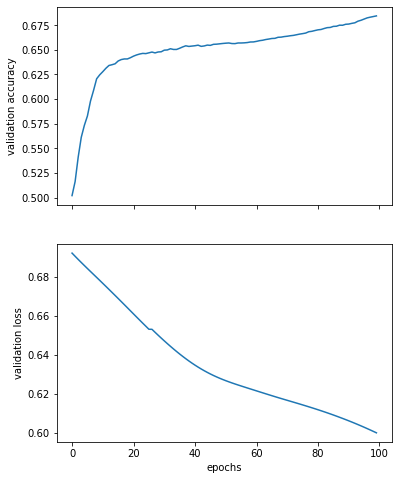

In [495]:
def plot_history(loss_list,  accuracy_list):
  fig, (ax1, ax2) = plt.subplots(2, figsize=(6, 8), sharex=True)

  ax1.plot(accuracy_list)
  ax1.set_ylabel("validation accuracy")
  ax2.plot(loss_list)
  ax2.set_ylabel("validation loss")
  ax2.set_xlabel("epochs")
  plt.show()

  return

plot_history(loss_list,  accuracy_list) 

In [496]:
from sklearn.metrics import accuracy_score
print(accuracy_score(y_test.detach().numpy(), y_pred.detach().numpy() > 0.5 ))

0.6845


# Classificação Multiclasse

A classe de saída é representada pelo *hot encode* da classe. Um atributo binário (ou saída) para cada classe.


In [521]:
df = pd.read_csv('http://meusite.mackenzie.br/rogerio/data_load/cardio_train.csv', sep=';')
df.head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,0


Precisaremos algo do tipo:

In [523]:
pd.concat( [ df.drop(columns='cardio'), pd.get_dummies(df.cardio) ], axis=1 ).head()

,id,age,gender,height,weight,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,0,1
0,0,18393,2,168,62.0,110,80,1,1,0,0,1,1,0
1,1,20228,1,156,85.0,140,90,3,1,0,0,1,0,1
2,2,18857,1,165,64.0,130,70,3,1,0,0,0,0,1
3,3,17623,2,169,82.0,150,100,1,1,0,0,1,0,1
4,4,17474,1,156,56.0,100,60,1,1,0,0,0,1,0


## Preparação dos dados

## Preparação dos dados `X`, `y`

Seleciona os atributos, faz a normalização das variáveis preditoras e emprega **`y` como um array 1-dimensional**. `X` e `y` ainda são transformados em **`np.arrays`** pois, diferentemente do `scikit-learn`, o `PyTorch` não aceita dataframes.

### Seleção de atributos

In [498]:
df = df.drop(columns='id')

### Normalização de `X`

In [499]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
scaler.fit_transform(df.drop(columns='cardio'))
X = scaler.transform(df.drop(columns='cardio'))

In [500]:
print( X[0:2] )

[[-0.43606151  1.36405487  0.44345206 -0.84787326 -0.12218198 -0.0882385
  -0.5393221  -0.39571994 -0.31087913 -0.23838436  0.49416711]
 [ 0.30768633 -0.73310834 -1.01816804  0.74983117  0.07261016 -0.03517999
   2.40079294 -0.39571994 -0.31087913 -0.23838436  0.49416711]]


### `y` e como `np.array` *n dimensional*

Onde $n$ é o número de classes. É o *hot encode* do atributo classe.

In [501]:
y = np.array( pd.get_dummies(df.cardio) )
print( y[0:10] )

[[1 0]
 [0 1]
 [0 1]
 [0 1]
 [1 0]
 [1 0]
 [1 0]
 [0 1]
 [1 0]
 [1 0]]


### Separação Treinamento e Teste

In [502]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train_hot, y_test_hot = train_test_split(X, y, test_size=0.2, random_state=123)

## `PyTorch` Classificação Binária

Emprega $n$ neurônios de saída, um para cada classe e `Cross Entropy` como função de erro para otimizar. 

In [503]:
import torch
import torch.nn as nn
from torch.autograd import Variable

In [504]:
class Model(nn.Module):
    def __init__(self, input_dim):
        super(Model, self).__init__()
        self.layer1 = nn.Linear(input_dim, 50)
        self.layer2 = nn.Linear(50, 50)
        self.layer3 = nn.Linear(50, 2)
        
    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = torch.relu(self.layer2(x))
        x = torch.softmax(self.layer3(x), dim=1)
        return x

model     = Model(X_train.shape[1])
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
loss_fn   = nn.CrossEntropyLoss()
model

X_train = Variable(torch.from_numpy(X_train)).float()
X_test  = Variable(torch.from_numpy(X_test)).float()

y_test_hot  = Variable(torch.from_numpy(y_test_hot)).float()
y_train_hot  = Variable(torch.from_numpy(y_train_hot)).float()

EPOCHS  = 100

loss_list     = np.zeros((EPOCHS,))
accuracy_list = np.zeros((EPOCHS,))

for epoch in tqdm.trange(EPOCHS):
    y_pred = model(X_train)
    loss = loss_fn(y_pred, y_train_hot)
    loss_list[epoch] = loss.item()
    
    # Zero gradients
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
    
    with torch.no_grad():
        y_pred = model(X_test)
        correct = (torch.argmax(y_pred, dim=1) == torch.argmax(y_test_hot, dim=1)).type(torch.FloatTensor)
        accuracy_list[epoch] = correct.mean()

100%|██████████| 100/100 [00:12<00:00,  7.96it/s]


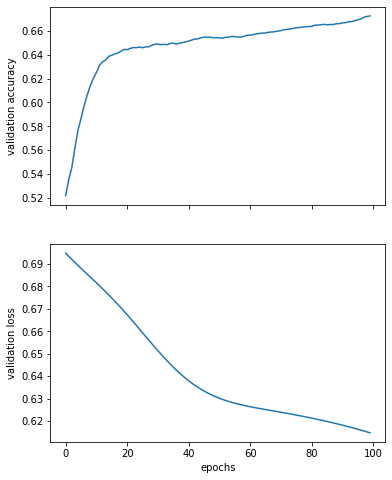

In [505]:
plot_history(loss_list,  accuracy_list) 

In [506]:
from sklearn.metrics import accuracy_score
print(accuracy_score(torch.argmax(y_test_hot, dim=1).detach().numpy(), torch.argmax(y_pred, dim=1).detach().numpy()))

0.6724285714285714
